In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
from pathlib import Path
import IPython.display as ipd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.7z
sample_submission.csv
test
test.7z
train
train.7z



In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
print(check_output(["ls", "../input/train"]).decode("utf8"))

folders = os.listdir("../input/train/audio")
print(folders)

audio
LICENSE
README.md
testing_list.txt
validation_list.txt

['on', 'validation_list.txt', 'yes', 'three', 'four', 'house', 'seven', 'marvin', 'no', 'eight', 'up', 'nine', 'stop', 'two', 'bed', 'cat', 'one', 'left', 'five', 'right', 'dog', 'wow', 'happy', 'testing_list.txt', 'down', 'six', 'go', 'off', '_background_noise_', 'sheila', 'zero', 'bird', 'tree']


## Some starter script to help with the data processing

In [4]:
train_audio_path = '../input/train/audio'

train_labels = os.listdir(train_audio_path)
train_labels=[u for u in train_labels if not u.endswith('.txt')]
train_labels.remove('_background_noise_')
print 'Number of labels:', len(train_labels)

labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence']

train_file_labels = dict()
for label in train_labels:
    files = os.listdir(train_audio_path + '/' + label)
    for f in files:
        train_file_labels[label + '/' + f] = label

train = pd.DataFrame.from_dict(train_file_labels, orient='index')
train = train.reset_index(drop=False)
train = train.rename(columns={'index': 'file', 0: 'folder'})
train = train[['folder', 'file']]
train = train.sort_values('file')
train = train.reset_index(drop=True)
print(train.shape)

def remove_label_from_file(label, fname):
    return fname[len(label)+1:]

train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

Number of labels: 30
(64721, 2)


In [5]:
train['path']=train.apply(lambda u: "train/audio/"+u['folder']+"/"+u['file'],1)

In [6]:
labels=sorted(list(set(train['label']))+['silence'])
str(labels)

"['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']"

In [7]:
labels_map={v:u for u,v in enumerate(labels)}

In [8]:
train['target']=train['label'].map(lambda u: labels_map[u])

In [9]:
train['subject']=train['file'].map(lambda u: u.split("_")[0])

In [10]:
subject_map={v:u for u,v in enumerate(np.random.permutation(list(set(train['subject']))))}
len(subject_map)

1881

In [11]:
train['subject_id']=train['subject'].map(lambda u: subject_map[u])

In [12]:
train['id']=np.random.permutation(range(len(train)))

In [13]:
train=train.sort_values(['id'])

In [14]:
train['id'].max(),train['id'].min()

(64720, 0)

In [15]:
train['fold']=train['subject_id'].map(lambda u: u%10)

In [16]:
train.head(5)

folder                   file    label  \
40645  seven  122c5aa7_nohash_2.wav  unknown   
22499   left  229978fd_nohash_0.wav     left   
21579  house  9e6bb505_nohash_1.wav  unknown   
40955  seven  34263ab3_nohash_0.wav  unknown   
37146    one  99a9b015_nohash_0.wav  unknown   

                                          path  target   subject  subject_id  \
40645  train/audio/seven/122c5aa7_nohash_2.wav       9  122c5aa7         417   
22499   train/audio/left/229978fd_nohash_0.wav       2  229978fd         332   
21579  train/audio/house/9e6bb505_nohash_1.wav       9  9e6bb505           8   
40955  train/audio/seven/34263ab3_nohash_0.wav       9  34263ab3        1283   
37146    train/audio/one/99a9b015_nohash_0.wav       9  99a9b015        1313   

       id  fold  
40645   0     7  
22499   1     2  
21579   2     8  
40955   3     3  
37146   4     3

In [17]:
train['fold'].value_counts()

1    6769
6    6720
3    6674
8    6580
5    6534
4    6498
0    6402
2    6401
7    6211
9    5932
Name: fold, dtype: int64

In [18]:
df=pd.pivot_table(train, index=['target'],columns=['fold'], values='id',aggfunc='count')
df=df/df.sum(0)
df

fold           0         1         2         3         4         5         6  \
target                                                                         
0       0.033115  0.035899  0.037807  0.036410  0.036319  0.037955  0.038393   
1       0.037644  0.037819  0.031245  0.038957  0.039397  0.037037  0.037351   
2       0.035770  0.037229  0.037182  0.035061  0.035703  0.037190  0.038542   
3       0.037488  0.035308  0.036088  0.039407  0.036781  0.036731  0.035863   
4       0.034052  0.033978  0.040619  0.036560  0.038781  0.037955  0.034673   
5       0.036551  0.037672  0.037182  0.036859  0.034010  0.035200  0.037500   
6       0.038582  0.036638  0.035619  0.039556  0.034780  0.038261  0.038393   
8       0.039831  0.040774  0.035307  0.034762  0.034010  0.039639  0.036756   
9       0.637613  0.628601  0.633182  0.632005  0.635426  0.624426  0.627083   
10      0.035926  0.037081  0.036713  0.036410  0.036934  0.037649  0.039435   
11      0.033427  0.039001  0.039056  0.034013  0.037858  0.037955  0.036012   

fold           7         8         9  
target                                
0       0.037192  0.037538  0.033547  
1       0.033489  0.036778  0.036413  
2       0.035904  0.034498  0.036413  
3       0.037836  0.037082  0.034221  
4       0.032845  0.038146  0.036581  
5       0.038319  0.036778  0.035570  
6       0.032845  0.034954  0.035738  
8       0.037353  0.034650  0.034390  
9       0.641765  0.635714  0.647168  
10      0.035260  0.037082  0.034053  
11      0.037192  0.036778  0.035907

In [19]:
train.to_csv("../info/train_info.csv",index=None)

In [20]:
train.shape

(64721, 9)

In [21]:
str(set(train['folder']))

"set(['sheila', 'seven', 'right', 'house', 'one', 'four', 'zero', 'go', 'yes', 'down', 'no', 'wow', 'six', 'three', 'bird', 'happy', 'marvin', 'stop', 'five', 'two', 'on', 'off', 'dog', 'tree', 'up', 'bed', 'cat', 'nine', 'eight', 'left'])"

In [22]:
str(set(train['label']))

"set(['on', 'right', 'off', 'no', 'unknown', 'stop', 'up', 'down', 'go', 'yes', 'left'])"

In [23]:
train['target'].value_counts()

9     41039
8      2380
11     2377
10     2375
3      2375
1      2372
6      2367
5      2367
0      2359
4      2357
2      2353
Name: target, dtype: int64

In [24]:
train['label'].value_counts()

unknown    41039
stop        2380
yes         2377
up          2375
no          2375
go          2372
on          2367
right       2367
down        2359
off         2357
left        2353
Name: label, dtype: int64

In [75]:
import scipy.io.wavfile as wavefile
import scipy.signal
import soundfile
import io
import hashlib
import librosa

In [107]:
def compressed_size0(x):
    compressed_array = io.BytesIO()     
    np.savez_compressed(compressed_array, x)
    a,b=x.nbytes,len(compressed_array.getvalue())
    #print a,b
    return float(b) 
def compressed_size1(fname):
    _,x=wavefile.read(fname)
    x=(x/2**8).astype(np.int8)
    #print x.dtype
    compressed_array = io.BytesIO()     
    np.savez_compressed(compressed_array, x)
    a,b=x.nbytes,len(compressed_array.getvalue())
    #print a,b
    return float(a)/b 
def compressed_size2(fname,window_size=.02,window_stride=.01,window='hamming'):
    y, sr = librosa.load(fname, sr=None)
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)

    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, phase = librosa.magphase(D)
    spect = np.log1p(spect)
    spect=spect/(spect.max()+1e-8)
    spect=(spect*255).astype(np.uint8)
    #print spect.max(),spect.nbytes,float(y.nbytes)/compressed_size0(spect)
    return float(y.nbytes)/compressed_size0(spect)

In [108]:
 (compressed_size2("../input/"+fname))

16.17386909274703

In [32]:
def hash_code(fname):
    return hashlib.sha256(open(fname, 'rb').read()).hexdigest()

In [27]:
train['path'].map(lambda u:u.split(".")[-1]).value_counts()

wav    64721
Name: path, dtype: int64

In [109]:
%time train['compress_ratio2']=train['path'].map(lambda u: compressed_size2("../input/"+u))

CPU times: user 5min 59s, sys: 17.4 s, total: 6min 16s
Wall time: 6min 19s


In [35]:
%time train['sha256']=train['path'].map(lambda u: hash_code("../input/"+u))

CPU times: user 12.3 s, sys: 1.54 s, total: 13.9 s
Wall time: 13.9 s


In [36]:
train.head()

folder                   file    label  \
40645  seven  122c5aa7_nohash_2.wav  unknown   
22499   left  229978fd_nohash_0.wav     left   
21579  house  9e6bb505_nohash_1.wav  unknown   
40955  seven  34263ab3_nohash_0.wav  unknown   
37146    one  99a9b015_nohash_0.wav  unknown   

                                          path  target   subject  subject_id  \
40645  train/audio/seven/122c5aa7_nohash_2.wav       9  122c5aa7         417   
22499   train/audio/left/229978fd_nohash_0.wav       2  229978fd         332   
21579  train/audio/house/9e6bb505_nohash_1.wav       9  9e6bb505           8   
40955  train/audio/seven/34263ab3_nohash_0.wav       9  34263ab3        1283   
37146    train/audio/one/99a9b015_nohash_0.wav       9  99a9b015        1313   

       id  fold  compress_ratio  \
40645   0     7        3.288798   
22499   1     2        3.429061   
21579   2     8        3.881611   
40955   3     3        3.182813   
37146   4     3        2.490272   

                                                  sha256  
40645  26e3afc4f075b489b452c5342626e7860ffd98eccd8ba3...  
22499  541b32a8bb26f90245e90b11f8b0da329efe102fb94369...  
21579  434fa2edb9abd738b5934eaf482d59681ac0e8b96a6d9f...  
40955  00dc435642ad0cb04948bca5d3706facdc52671005a9d2...  
37146  098434b25b48c8ff58037a6780a53d5ded4028233d361b...

In [40]:
train['sha256'].value_counts().value_counts()

1    63914
2      351
3       35
Name: sha256, dtype: int64

In [113]:
df=train.sort_values('compress_ratio2',ascending=False) 

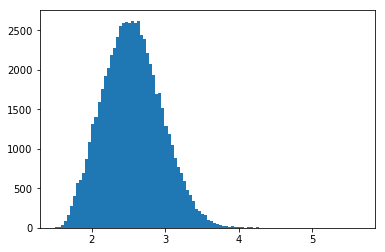

In [114]:
plt.hist(np.log(train['compress_ratio2']),100);

In [127]:
df[:100].tail()

folder                   file    label  \
41975  seven  9ff1b8b6_nohash_1.wav  unknown   
31887    off  5fadb538_nohash_4.wav      off   
34244     on  5fadb538_nohash_2.wav       on   
42814  seven  f59d0771_nohash_0.wav  unknown   
15709   four  ba770f9b_nohash_0.wav  unknown   

                                          path  target   subject  subject_id  \
41975  train/audio/seven/9ff1b8b6_nohash_1.wav       9  9ff1b8b6        1211   
31887    train/audio/off/5fadb538_nohash_4.wav       4  5fadb538         258   
34244     train/audio/on/5fadb538_nohash_2.wav       5  5fadb538         258   
42814  train/audio/seven/f59d0771_nohash_0.wav       9  f59d0771        1093   
15709   train/audio/four/ba770f9b_nohash_0.wav       9  ba770f9b         475   

          id  fold  compress_ratio  \
41975  32152     1        5.816067   
31887  35333     8        4.895961   
34244  28361     8        3.819527   
42814  41770     3        7.369876   
15709  22696     5        9.931719   

                                                  sha256  compress_ratio2  
41975  d05ebab282d45186f2a69a65284e51a687841b425b0c50...        46.376812  
31887  374b4551285c21bbab722b4af516542a8812c061c4a68b...        46.343230  
34244  245a1cac4199c2ab452de90b9c72e0cf80180032c2e8ea...        46.343230  
42814  4d6599699b999e308957819be431c2934a2dc48eab52c9...        46.276211  
15709  70d44244c9a2cffc029069c89523c46cda62b954ce5f00...        46.276211

In [117]:
np.log(df['compress_ratio2']).describe()

count    64721.000000
mean         2.554753
std          0.393723
min          1.500373
25%          2.271813
50%          2.540684
75%          2.816279
max          5.637293
Name: compress_ratio2, dtype: float64

on

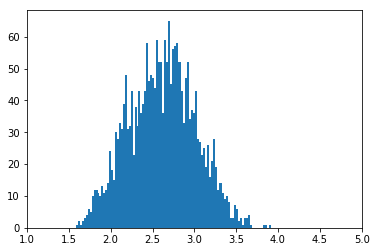

 right

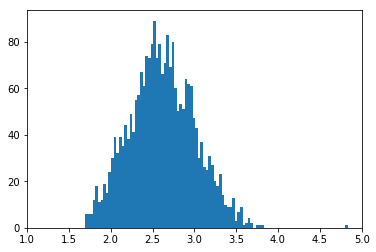

 off

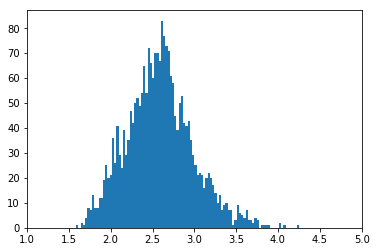

 no

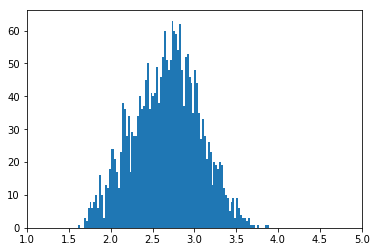

 unknown

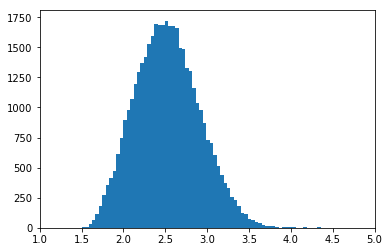

 stop

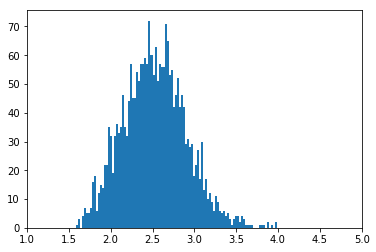

 up

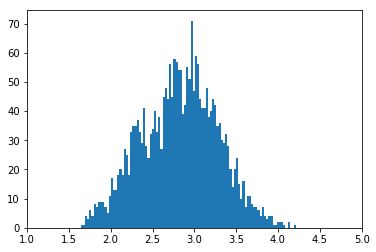

 down

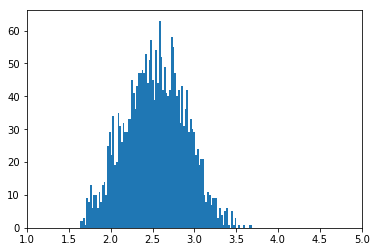

 go

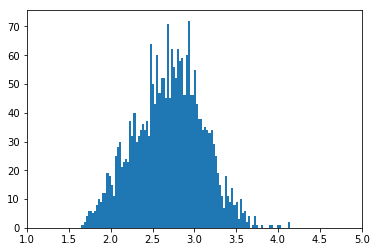

 yes

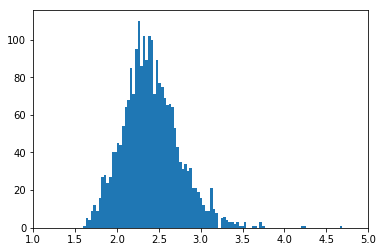

 left

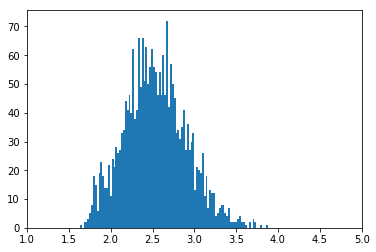

In [134]:
for label in set(df['label']):
    subdf=df[df.label==label]
    print label,
    plt.hist(np.log(subdf['compress_ratio2']),bins=100);
    xlim([1,5])
    plt.show()

In [202]:
np.exp(2.554753+3*0.393723),np.exp(2.554753-3*0.393723)

(41.926664132315125, 3.9494802974852248)

In [149]:
removed=df[df['compress_ratio2']>42]
removed.shape

(170, 12)

In [150]:
a=removed[-20:]
for i in a.index:
    s=a.loc[i]
    fname=s['path']
    label=s['label']
    print label,fname
    display(ipd.Audio(wavefile.read('../input/'+fname)[1],rate=16000))


off train/audio/off/5fadb538_nohash_0.wav


off train/audio/off/76424fa5_nohash_0.wav


no train/audio/no/712e4d58_nohash_1.wav


up train/audio/up/dca2797e_nohash_1.wav


right train/audio/right/9ff1b8b6_nohash_1.wav


go train/audio/go/712e4d58_nohash_1.wav


up train/audio/up/cab100c9_nohash_1.wav


unknown train/audio/four/d90b4138_nohash_1.wav


unknown train/audio/three/ba770f9b_nohash_0.wav


up train/audio/up/f92e49f3_nohash_0.wav


unknown train/audio/four/ba770f9b_nohash_1.wav


off train/audio/off/b16f2d0d_nohash_1.wav


unknown train/audio/wow/3ea77ede_nohash_0.wav


unknown train/audio/two/5fadb538_nohash_4.wav


up train/audio/up/735845ab_nohash_2.wav


unknown train/audio/three/dedc7fab_nohash_0.wav


unknown train/audio/two/5fadb538_nohash_3.wav


off train/audio/off/fb01a182_nohash_0.wav


unknown train/audio/bird/bdb90d38_nohash_1.wav


off train/audio/off/cc6ee39b_nohash_2.wav


In [153]:
a=df[-20:]
for i in a.index:
    s=a.loc[i]
    fname=s['path']
    label=s['label']
    print label,fname
    display(ipd.Audio(wavefile.read('../input/'+fname)[1],rate=16000))


off train/audio/off/aff582a1_nohash_2.wav


unknown train/audio/house/5165cf0a_nohash_0.wav


unknown train/audio/six/712e4d58_nohash_1.wav


on train/audio/on/ad9de4dd_nohash_0.wav


unknown train/audio/cat/5165cf0a_nohash_0.wav


unknown train/audio/seven/38d78313_nohash_2.wav


unknown train/audio/five/ad9de4dd_nohash_0.wav


unknown train/audio/six/e5dadd24_nohash_1.wav


unknown train/audio/zero/763188c4_nohash_3.wav


unknown train/audio/eight/735845ab_nohash_4.wav


unknown train/audio/zero/5165cf0a_nohash_0.wav


unknown train/audio/house/ad9de4dd_nohash_0.wav


unknown train/audio/five/ad9de4dd_nohash_1.wav


unknown train/audio/one/a7dd45cf_nohash_1.wav


unknown train/audio/sheila/5165cf0a_nohash_0.wav


unknown train/audio/seven/b1114e4f_nohash_0.wav


unknown train/audio/sheila/6940f7f3_nohash_0.wav


unknown train/audio/six/7e7f0ed6_nohash_0.wav


unknown train/audio/house/5165cf0a_nohash_1.wav


unknown train/audio/five/5165cf0a_nohash_0.wav


In [155]:
train['clear']=1
train.loc[train['compress_ratio2']>42,'clear']=0

In [157]:
train=train.drop(['folder','file'],axis=1)

In [158]:
train.head()

label                                     path  target   subject  \
40645  unknown  train/audio/seven/122c5aa7_nohash_2.wav       9  122c5aa7   
22499     left   train/audio/left/229978fd_nohash_0.wav       2  229978fd   
21579  unknown  train/audio/house/9e6bb505_nohash_1.wav       9  9e6bb505   
40955  unknown  train/audio/seven/34263ab3_nohash_0.wav       9  34263ab3   
37146  unknown    train/audio/one/99a9b015_nohash_0.wav       9  99a9b015   

       subject_id  id  fold  compress_ratio  \
40645         417   0     7        3.288798   
22499         332   1     2        3.429061   
21579           8   2     8        3.881611   
40955        1283   3     3        3.182813   
37146        1313   4     3        2.490272   

                                                  sha256  compress_ratio2  \
40645  26e3afc4f075b489b452c5342626e7860ffd98eccd8ba3...        11.617353   
22499  541b32a8bb26f90245e90b11f8b0da329efe102fb94369...        19.838810   
21579  434fa2edb9abd738b5934eaf482d59681ac0e8b96a6d9f...        10.512484   
40955  00dc435642ad0cb04948bca5d3706facdc52671005a9d2...         7.716422   
37146  098434b25b48c8ff58037a6780a53d5ded4028233d361b...        11.935845   

       clear  
40645      1  
22499      1  
21579      1  
40955      1  
37146      1

In [159]:
train.to_csv("../info/train_info.csv",index=None)

In [177]:
train.shape

(64721, 11)

In [171]:
testfiles=os.listdir("../input/test/audio/")
testfiles= ['test/audio/'+u for u in testfiles if u.endswith('.wav')]
len(testfiles)

158538

In [172]:
testfiles[0]

'test/audio/clip_2527ac72d.wav'

In [173]:
test=train[train['id']==-1]

In [180]:
test['path']=testfiles
test['id']=test.index+100000
test['fold']= [u%10 for u in np.random.permutation(range(len(test)))]

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [182]:
%time test['sha256']=test['path'].map(lambda u: hash_code("../input/"+u))

CPU times: user 30.5 s, sys: 3.98 s, total: 34.5 s
Wall time: 34.5 s


/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [183]:
%time test['compress_ratio2']=test['path'].map(lambda u: compressed_size2("../input/"+u))

CPU times: user 14min 56s, sys: 43.3 s, total: 15min 39s
Wall time: 15min 47s


/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [184]:
test.head()

label                           path  target subject  subject_id      id  \
0   NaN  test/audio/clip_2527ac72d.wav     NaN     NaN         NaN  100000   
1   NaN  test/audio/clip_d9da3de66.wav     NaN     NaN         NaN  100001   
2   NaN  test/audio/clip_031fe4f96.wav     NaN     NaN         NaN  100002   
3   NaN  test/audio/clip_5f735ef11.wav     NaN     NaN         NaN  100003   
4   NaN  test/audio/clip_9c2407f9e.wav     NaN     NaN         NaN  100004   

   fold  compress_ratio                                             sha256  \
0     0             NaN  f984cdc776c43812c6721fad2568a130d758884c1157f0...   
1     6             NaN  12722dbd562910e47b4bc4702bd314a3e23df1f49c31e9...   
2     9             NaN  38564696e8e68cea84f93f434e45bb02772c6cb25d29d6...   
3     6             NaN  faa405f0f72ff5b7ed09539caa54576d75bb2098d27fe4...   
4     2             NaN  6eeada169a16368d59c6c6877790bfd2200bc2e87c7be4...   

   compress_ratio2  clear  
0        22.432527    NaN  
1        16.194332    NaN  
2         4.252774    NaN  
3        27.234043    NaN  
4        11.825573    NaN

In [190]:
test.shape

(158538, 11)

In [191]:
test.sha256.value_counts().head()

643f8a8dc8bd9c19225afffad2becfec5426180b3749cb208abdf1a6c8354efc    3709
5503d39f160f388dc423fecd1a16a53d46c7f393b5d667269c239e42302b19f0       6
3cebaf50d7ccbcf33a6e884699129826a7e7850bb70d2066c05e9558b0af5ce9       5
4806dca22f1c58973b832581fb5b974dbc52f138f55ffec0590520253c23e153       5
9c62d119882e94ae1507fcdc256d0ce9763d0b56898d808aef1030e11010058d       4
Name: sha256, dtype: int64

In [189]:
test.sha256.value_counts().value_counts()

1       151994
2         1150
3          137
4           27
5            2
3709         1
6            1
Name: sha256, dtype: int64

In [192]:
test=test.groupby('sha256').first()
test.shape

(153312, 10)

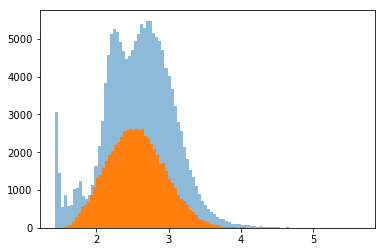

In [196]:
plt.hist(np.log(test.compress_ratio2),bins=100,alpha=0.5);
plt.hist(np.log(train.compress_ratio2),bins=100);

In [231]:
test['clear']=1
test.loc[test.compress_ratio2<7,'clear']=0
test.loc[test.compress_ratio2>42,'clear']=0

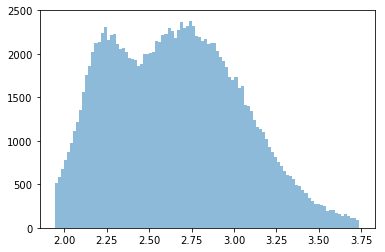

In [232]:
plt.hist(np.log(test.compress_ratio2[test.clear==1]),bins=100,alpha=0.5);


In [233]:
np.log(test.compress_ratio2[test.clear==1]).describe()

count    138632.000000
mean          2.653079
std           0.378063
min           1.946004
25%           2.338374
50%           2.640903
75%           2.922249
max           3.737545
Name: compress_ratio2, dtype: float64

In [195]:
np.log(train.compress_ratio2).describe()

count    64721.000000
mean         2.554753
std          0.393723
min          1.500373
25%          2.271813
50%          2.540684
75%          2.816279
max          5.637293
Name: compress_ratio2, dtype: float64

In [234]:
print len(test.index.intersection(train.sha256))
test.loc[test.index.intersection(train.sha256),'clear']=0

57


In [235]:
(test.clear==1).sum(),test.shape

(138579, (153312, 10))

In [237]:
test=test.reset_index().loc[:,train.columns]

In [238]:
test.head()

label                           path  target  subject  subject_id      id  \
0    NaN  test/audio/clip_406fbf1d4.wav     NaN      NaN         NaN  253348   
1    NaN  test/audio/clip_2e458d075.wav     NaN      NaN         NaN  256725   
2    NaN  test/audio/clip_d025985eb.wav     NaN      NaN         NaN  141339   
3    NaN  test/audio/clip_cf9ecec71.wav     NaN      NaN         NaN  159286   
4    NaN  test/audio/clip_a6fc03916.wav     NaN      NaN         NaN  174977   

   fold  compress_ratio                                             sha256  \
0     3             NaN  00000edcd9ea08a85c73855380535ec2c5f548ae0683e6...   
1     1             NaN  0000e856608966890229d213fe7608b934940987f42e78...   
2     8             NaN  000145ee640107576eb5e55f13b83aa1d3377264a85019...   
3     6             NaN  0001a077372dcbbf4247d3df4da43de2051c4a6cb52064...   
4     6             NaN  000211515d30b992480dbc31e77b4459e0c317eac51c60...   

   compress_ratio2  clear  
0        50.393701      0  
1         4.263824      0  
2        22.145329      1  
3        23.477623      1  
4        11.951447      1

In [239]:
test.to_csv("../info/test_info.csv",header=None)

In [197]:
df=test.sort_values("compress_ratio2",ascending=False)

In [199]:
a=df[-20:]
for i in a.index:
    s=a.loc[i]
    fname=s['path']
    label=s['label']
    print label,fname, s['compress_ratio2']
    display(ipd.Audio(wavefile.read('../input/'+fname)[1],rate=16000))


nan test/audio/clip_2c7bad507.wav 4.19479583142


nan test/audio/clip_040593491.wav 4.19452090707


nan test/audio/clip_39768133d.wav 4.19342156991


nan test/audio/clip_6ca0e6702.wav 4.19314682566


nan test/audio/clip_42d748c53.wav 4.19177364422


nan test/audio/clip_a0d0d7d9a.wav 4.19177364422


nan test/audio/clip_351b59496.wav 4.19095016698


nan test/audio/clip_eefeb18eb.wav 4.19067574646


nan test/audio/clip_57ed16be0.wav 4.18930418276


nan test/audio/clip_9b90f9c1c.wav 4.18601609


nan test/audio/clip_b1109cdfc.wav 4.18574231524


nan test/audio/clip_6b8d283c6.wav 4.1827331547


nan test/audio/clip_8977db7b2.wav 4.18054739042


nan test/audio/clip_efe20f375.wav 4.17863671977


nan test/audio/clip_a25a599ac.wav 4.17809113461


nan test/audio/clip_1684e6942.wav 4.17291517246


nan test/audio/clip_27d8023f4.wav 4.17101147028


nan test/audio/clip_4cbefbd03.wav 4.16802344513


nan test/audio/clip_9f8b046f6.wav 4.16612420258


nan test/audio/clip_e7d69e696.wav 4.16097782979


In [201]:
a=df[:20]
for i in a.index:
    s=a.loc[i]
    fname=s['path']
    label=s['label']
    print label,fname, s['compress_ratio2']
    display(ipd.Audio(wavefile.read('../input/'+fname)[1],rate=16000))


nan test/audio/clip_530054ecd.wav 280.701754386


nan test/audio/clip_7313c56b6.wav 179.271708683


nan test/audio/clip_933ac886d.wav 173.913043478


nan test/audio/clip_54def46bf.wav 168.865435356


nan test/audio/clip_914c2ccab.wav 167.101827676


nan test/audio/clip_b147c25c7.wav 160.0


nan test/audio/clip_402bc7486.wav 157.63546798


nan test/audio/clip_f0e7cf7a8.wav 156.862745098


nan test/audio/clip_b6bae64cd.wav 146.118721461


nan test/audio/clip_077103162.wav 140.350877193


nan test/audio/clip_c86e0fb30.wav 139.737991266


nan test/audio/clip_adfe8ccd1.wav 135.306553911


nan test/audio/clip_d7de9ec6f.wav 134.171907757


nan test/audio/clip_968f170ce.wav 133.333333333


nan test/audio/clip_1371cd208.wav 123.552123552


nan test/audio/clip_8baeec4ed.wav 119.850187266


nan test/audio/clip_049aac480.wav 119.402985075


nan test/audio/clip_f4e192069.wav 115.107913669


nan test/audio/clip_73b238eb3.wav 114.901256732


nan test/audio/clip_6d3a0afa9.wav 114.695340502


In [48]:
wavefile.read('../input/'+'train/audio/bird/3e7124ba_nohash_0.wav')

(16000, array([0, 0, 0, ..., 0, 0, 0], dtype=int16))